In [466]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [467]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
#from monetio.models import hysplit

In [468]:
from monetio.models import hysplit

In [469]:
from utilvolc import volcat
import utilvolc.ash_inverse as ai
from utilvolc import ashapp

In [470]:
from utilvolc.ashapp import ashinverse

In [471]:
os.chdir('/hysplit-users/alicec/projects/bezy/notebooks/')
projdir = os.getcwd().replace('notebooks','')

vloc = [160.587,55.978]
tag ='B'
#ens = ['gep{:02d}'.format(x) for x in np.arange(1,31)]
#ens.append('gec00')
#ens=['gep04','gep03']

#----------------------------------------------------------------
# locations and names of netcdf files with cdump output.
tdir = os.path.join(projdir,'data')
fnamelist  = ['xrfile.invbezy{}.nc'.format(tag)]
tdirlist = [tdir]

#----------------------------------------------------------------
configdir = os.path.join(projdir,'RunB')
configfile = 'config.invbezy{}.txt'.format(tag)

#-----------------------------------------------------------------
# location of volcat files
vdir = os.path.join(projdir,'data','volcat')
# volcano id to locate
vid = 'v300250'
#-----------------------------------------------------------------
# Location of inverse algorithm output
#wpath = os.getcwd()
wdir = os.path.join(projdir,'RunB')
#print(wpath)
#cdir = '../Run{}/'.format(tag)
#wdir = '../Run{}/'.format(tag,tag)
#sdir = os.path.join(wdir,'RunM_1_2_3_4_TF')
name = 'out.dat'
name2 = 'out2.dat'
#------------------------------------------------------------------

# name to write emit-times file to.
emit_file_name = '{}emit_Run{}4.txt'.format(wdir,tag)
tcm_name_base = 'run{}zzz.tcm.txt'.format(tag)
figbase = 'Run{}4'.format(tag)

#-------------------------------------------------------------------
#

execdir = os.path.join(projdir,'Inverse_240')
hysplitdir = os.path.join(projdir,'hysplit')
#execdir = mdir+'/Inverse_'
print(execdir, hysplitdir)
print(vdir)
#

datadir = os.path.join(projdir, 'data')

/hysplit-users/alicec/projects/bezy/Inverse_240 /hysplit-users/alicec/projects/bezy/hysplit
/hysplit-users/alicec/projects/bezy/data/volcat


In [506]:
%autoreload
#time list to prepare.
# start with one hour after eruption. 21:00-22:00
dlist = []
sdate = datetime.datetime(2020,10,21,21,0)
#sdate = datetime.datetime(2020,10,22,12,0)
dt = datetime.timedelta(hours=1)
for iii in np.arange(0,10):
    drange = [sdate, sdate+dt]
    dlist.append(drange)
    sdate += dt
print(dlist[0])
print(dlist[-1])

[datetime.datetime(2020, 10, 21, 21, 0), datetime.datetime(2020, 10, 21, 22, 0)]
[datetime.datetime(2020, 10, 22, 6, 0), datetime.datetime(2020, 10, 22, 7, 0)]


In [507]:
# initiate the InverseAshEns object
%autoreload
inverse = ai.InverseAshEns(tdirlist,fnamelist,vdir,vid,configdir=configdir,configfile=configfile,verbose=False)

In [508]:
print(inverse.invlist[0].get_time(2))
print(inverse.invlist[0].get_time(4))

2020-10-21 21:00:00
2020-10-21 23:00:00


In [509]:
%autoreload
inverse.set_directory(wdir,execdir,datadir,hysplitdir)
inverse.print_directories()

Working directory, wdir :/hysplit-users/alicec/projects/bezy/RunB
execdir :/hysplit-users/alicec/projects/bezy/Inverse_240
hysplitdir :/hysplit-users/alicec/projects/bezy/hysplit
subdir :/hysplit-users/alicec/projects/bezy/RunB
vdir :/hysplit-users/alicec/projects/bezy/data/volcat
datadir :/hysplit-users/alicec/projects/bezy/data


In [510]:
inva = inverse.invlist[0]
inva.cdump.coords

Coordinates:
  * time       (time) datetime64[ns] 2020-10-21T19:00:00 ... 2020-10-22T11:00:00
  * z          (z) int64 1523 3047 4571 6095 7619 9143 10667 12191 13715 15239
  * y          (y) int64 376 377 378 379 380 381 382 ... 480 481 482 483 484 485
  * x          (x) int64 866 867 868 869 870 871 872 ... 947 948 949 950 951 952
  * ens        (ens) object '102119_2880' '102119_3880' ... '102200_12880'
    source     <U13 'Line to 14 km'
    latitude   (y, x) float64 ...
    longitude  (y, x) float64 ...

In [511]:
# add in the relavant VOLCAT observations
%autoreload
#dlist = [[datetime.datetime(2020,10,22,9),datetime.datetime(2020,10,22,10)]]
for drange in dlist:
    print(drange)
    inverse.prepare_one_time(drange)

[datetime.datetime(2020, 10, 21, 21, 0), datetime.datetime(2020, 10, 21, 22, 0)]
[datetime.datetime(2020, 10, 21, 22, 0), datetime.datetime(2020, 10, 21, 23, 0)]
[datetime.datetime(2020, 10, 21, 23, 0), datetime.datetime(2020, 10, 22, 0, 0)]
[datetime.datetime(2020, 10, 22, 0, 0), datetime.datetime(2020, 10, 22, 1, 0)]
[datetime.datetime(2020, 10, 22, 1, 0), datetime.datetime(2020, 10, 22, 2, 0)]
[datetime.datetime(2020, 10, 22, 2, 0), datetime.datetime(2020, 10, 22, 3, 0)]
[datetime.datetime(2020, 10, 22, 3, 0), datetime.datetime(2020, 10, 22, 4, 0)]
[datetime.datetime(2020, 10, 22, 4, 0), datetime.datetime(2020, 10, 22, 5, 0)]
[datetime.datetime(2020, 10, 22, 5, 0), datetime.datetime(2020, 10, 22, 6, 0)]
[datetime.datetime(2020, 10, 22, 6, 0), datetime.datetime(2020, 10, 22, 7, 0)]


In [512]:
for tii in [1,2,3,4,5,6,7,8,9,10,11]:
    print('time {} : {}'.format(tii,inverse.invlist[0].get_time(tii)))


time 1 : 2020-10-21 20:00:00
time 2 : 2020-10-21 21:00:00
time 3 : 2020-10-21 22:00:00
time 4 : 2020-10-21 23:00:00
time 5 : 2020-10-22 00:00:00
time 6 : 2020-10-22 01:00:00
time 7 : 2020-10-22 02:00:00
time 8 : 2020-10-22 03:00:00
time 9 : 2020-10-22 04:00:00
time 10 : 2020-10-22 05:00:00
time 11 : 2020-10-22 06:00:00


In [479]:
%autoreload
inverse.invlist[0].print_summary()

Observations availalbe in volcat_avg_hash
dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
times in cdump file
2020 10 21 19:00z
2020 10 21 20:00z
2020 10 21 21:00z
2020 10 21 22:00z
2020 10 21 23:00z
2020 10 22 00:00z
2020 10 22 01:00z
2020 10 22 02:00z
2020 10 22 03:00z
2020 10 22 04:00z
2020 10 22 05:00z
2020 10 22 06:00z
2020 10 22 07:00z
2020 10 22 08:00z
2020 10 22 09:00z
2020 10 22 10:00z
2020 10 22 11:00z


10 bezyB
tii 10


/hysplit-users/alicec/anaconda3/envs/paris/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


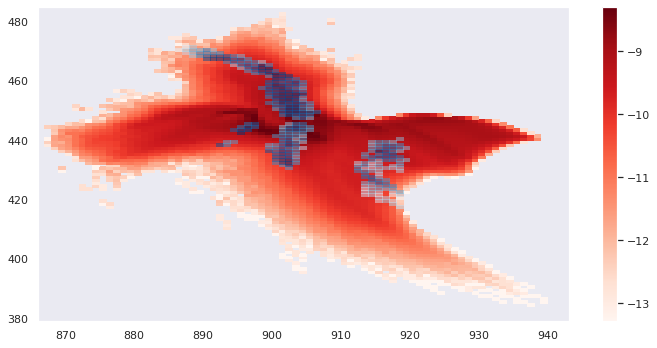

In [480]:
%autoreload
#gep10, gep16 looks good at tii=6.
#gep24 possibly looks ok.
zlevel=None  #index 'ensemble'
           #if None then sum along the ens. dimension which shows contributions from all inv. runs.
tii=10
#zlevel=None
%autoreload
ax = inverse.compare_plotsA(daterange=dlist[0],tii=tii,zii=zlevel)
#plt.gca()
#ax.plot(160.587,55.978,'y^')
#plt.show()


In [481]:
%autoreload
inverse.set_concmult(1)

# Automatic Runs

In [489]:
def makerun(tii,remove_cols, remove_rows, remove_sources,remove_ncs):
    print("HERE HERE HERE")
    inverse.make_tcm_mult(tii,remove_cols=remove_cols, remove_rows=remove_rows, remove_sources=remove_sources,remove_ncs=remove_ncs)
    runtag = ai.create_runtag(tag,tii,remove_cols, remove_rows, remove_sources,remove_ncs=remove_ncs)
    inverse.set_subdirectory(runtag)
    print('HERE', inverse.subdir)
    tcmstr = inverse.write_tcm(os.path.join(inverse.subdir, tcm_name_base.replace('zzz','4')))
    inverse.run_tcm()
    
    eii=None
    unit='g/h'
    unit='kg/s'
    inverse.plot_outdat_ts(eii,unit=unit)
    #plt.show()
    #inverse.plot_outdat_ts(eii,profile=True)
    inverse.save_emis(runtag+'.csv')


## Run with all previous and just two previous

tii [2, 3, 4, 5]
HERE HERE HERE
2020-10-21T21:00:00.000000000
2020-10-21T22:00:00.000000000
2020-10-21T23:00:00.000000000
2020-10-22T00:00:00.000000000
HERE /hysplit-users/alicec/projects/bezy/RunB/RunB_2_3_4_5_TFw5
(7933, 67)
N_ctrl 66
output file /hysplit-users/alicec/projects/bezy/RunB/RunB_2_3_4_5_TFw5/runB4.tcm_bezyB.txt


/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:829: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.latlist = np.array(latlist)
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:830: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.lonlist = np.array(lonlist)
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:844: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, yo

bezyB


No meteorological files found /hysplit-users/alicec/projects/bezy/data/%Y%m%d/hysplit.t%Hz.gfs0p25f


saving to  /hysplit-users/alicec/projects/bezy/RunB/RunB_2_3_4_5_TFw5/RunB_2_3_4_5_TFw5.csv
writing efile {} /hysplit-users/alicec/projects/bezy/RunB/RunB_2_3_4_5_TFw5/bezyB_emit.txt
gfs0p25
fcst str /pub/forecast/%Y%m%d/
making control file  gfs0p25
/hysplit-users/alicec/projects/bezy/data/
fcst str /hysplit-users/alicec/projects/bezy/data/%Y%m%d/
WARNING /hysplit-users/alicec/projects/bezy/data/20201021/hysplit.t18z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t00z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t06z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t12z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t18z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201023/hysplit.t00z.gfs

/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:829: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.latlist = np.array(latlist)
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:830: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.lonlist = np.array(lonlist)
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:844: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, yo

bezyB


/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:596: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(1,1,1)
No meteorological files found /hysplit-users/alicec/projects/bezy/data/%Y%m%d/hysplit.t%Hz.gfs0p25f


saving to  /hysplit-users/alicec/projects/bezy/RunB/RunB_2_3_4_5_6_TFw5/RunB_2_3_4_5_6_TFw5.csv
writing efile {} /hysplit-users/alicec/projects/bezy/RunB/RunB_2_3_4_5_6_TFw5/bezyB_emit.txt
gfs0p25
fcst str /pub/forecast/%Y%m%d/
making control file  gfs0p25
/hysplit-users/alicec/projects/bezy/data/
fcst str /hysplit-users/alicec/projects/bezy/data/%Y%m%d/
WARNING /hysplit-users/alicec/projects/bezy/data/20201021/hysplit.t18z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t00z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t06z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t12z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t18z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201023/hysplit.t0

/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:829: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.latlist = np.array(latlist)
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:830: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.lonlist = np.array(lonlist)
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:844: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, yo

bezyB


/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:596: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(1,1,1)
No meteorological files found /hysplit-users/alicec/projects/bezy/data/%Y%m%d/hysplit.t%Hz.gfs0p25f


saving to  /hysplit-users/alicec/projects/bezy/RunB/RunB_2_3_4_5_6_7_TFw5/RunB_2_3_4_5_6_7_TFw5.csv
writing efile {} /hysplit-users/alicec/projects/bezy/RunB/RunB_2_3_4_5_6_7_TFw5/bezyB_emit.txt
gfs0p25
fcst str /pub/forecast/%Y%m%d/
making control file  gfs0p25
/hysplit-users/alicec/projects/bezy/data/
fcst str /hysplit-users/alicec/projects/bezy/data/%Y%m%d/
WARNING /hysplit-users/alicec/projects/bezy/data/20201021/hysplit.t18z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t00z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t06z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t12z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t18z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201023/hysp

/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:829: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.latlist = np.array(latlist)
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:830: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.lonlist = np.array(lonlist)
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:844: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, yo

bezyB


/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:596: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(1,1,1)
No meteorological files found /hysplit-users/alicec/projects/bezy/data/%Y%m%d/hysplit.t%Hz.gfs0p25f


saving to  /hysplit-users/alicec/projects/bezy/RunB/RunB_2_3_4_5_6_7_8_TFw5/RunB_2_3_4_5_6_7_8_TFw5.csv
writing efile {} /hysplit-users/alicec/projects/bezy/RunB/RunB_2_3_4_5_6_7_8_TFw5/bezyB_emit.txt
gfs0p25
fcst str /pub/forecast/%Y%m%d/
making control file  gfs0p25
/hysplit-users/alicec/projects/bezy/data/
fcst str /hysplit-users/alicec/projects/bezy/data/%Y%m%d/
WARNING /hysplit-users/alicec/projects/bezy/data/20201021/hysplit.t18z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t00z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t06z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t12z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t18z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/2020102

/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:829: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.latlist = np.array(latlist)
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:830: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.lonlist = np.array(lonlist)
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:844: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, yo

bezyB


/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:596: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(1,1,1)


saving to  /hysplit-users/alicec/projects/bezy/RunB/RunB_2_3_4_5_6_7_8_9_TFw5/RunB_2_3_4_5_6_7_8_9_TFw5.csv
writing efile {} /hysplit-users/alicec/projects/bezy/RunB/RunB_2_3_4_5_6_7_8_9_TFw5/bezyB_emit.txt


No meteorological files found /hysplit-users/alicec/projects/bezy/data/%Y%m%d/hysplit.t%Hz.gfs0p25f


gfs0p25
fcst str /pub/forecast/%Y%m%d/
making control file  gfs0p25
/hysplit-users/alicec/projects/bezy/data/
fcst str /hysplit-users/alicec/projects/bezy/data/%Y%m%d/
WARNING /hysplit-users/alicec/projects/bezy/data/20201021/hysplit.t18z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t00z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t06z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t12z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t18z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201023/hysplit.t00z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201023/hysplit.t06z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alic

/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:829: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.latlist = np.array(latlist)
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:830: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.lonlist = np.array(lonlist)
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:844: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, yo

bezyB


/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:596: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(1,1,1)


saving to  /hysplit-users/alicec/projects/bezy/RunB/RunB_2_3_4_5_6_7_8_9_10_TFw5/RunB_2_3_4_5_6_7_8_9_10_TFw5.csv
writing efile {} /hysplit-users/alicec/projects/bezy/RunB/RunB_2_3_4_5_6_7_8_9_10_TFw5/bezyB_emit.txt


No meteorological files found /hysplit-users/alicec/projects/bezy/data/%Y%m%d/hysplit.t%Hz.gfs0p25f


gfs0p25
fcst str /pub/forecast/%Y%m%d/
making control file  gfs0p25
/hysplit-users/alicec/projects/bezy/data/
fcst str /hysplit-users/alicec/projects/bezy/data/%Y%m%d/
WARNING /hysplit-users/alicec/projects/bezy/data/20201021/hysplit.t18z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t00z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t06z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t12z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t18z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201023/hysplit.t00z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201023/hysplit.t06z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alic

/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:829: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.latlist = np.array(latlist)
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:830: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.lonlist = np.array(lonlist)
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:844: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, yo

bezyB


/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:596: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(1,1,1)
No meteorological files found /hysplit-users/alicec/projects/bezy/data/%Y%m%d/hysplit.t%Hz.gfs0p25f


saving to  /hysplit-users/alicec/projects/bezy/RunB/RunB_2_3_4_5_6_7_8_9_10_11_TFw5/RunB_2_3_4_5_6_7_8_9_10_11_TFw5.csv
writing efile {} /hysplit-users/alicec/projects/bezy/RunB/RunB_2_3_4_5_6_7_8_9_10_11_TFw5/bezyB_emit.txt
gfs0p25
fcst str /pub/forecast/%Y%m%d/
making control file  gfs0p25
/hysplit-users/alicec/projects/bezy/data/
fcst str /hysplit-users/alicec/projects/bezy/data/%Y%m%d/
WARNING /hysplit-users/alicec/projects/bezy/data/20201021/hysplit.t18z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t00z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t06z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t12z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t18z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/pr

/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:829: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.latlist = np.array(latlist)
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:830: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.lonlist = np.array(lonlist)
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:844: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, yo

bezyB


/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:596: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(1,1,1)
No meteorological files found /hysplit-users/alicec/projects/bezy/data/%Y%m%d/hysplit.t%Hz.gfs0p25f


saving to  /hysplit-users/alicec/projects/bezy/RunB/RunB_2_3_TFw5/RunB_2_3_TFw5.csv
writing efile {} /hysplit-users/alicec/projects/bezy/RunB/RunB_2_3_TFw5/bezyB_emit.txt
gfs0p25
fcst str /pub/forecast/%Y%m%d/
making control file  gfs0p25
/hysplit-users/alicec/projects/bezy/data/
fcst str /hysplit-users/alicec/projects/bezy/data/%Y%m%d/
WARNING /hysplit-users/alicec/projects/bezy/data/20201021/hysplit.t18z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t00z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t06z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t12z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t18z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201023/hysplit.t00z.gfs0p25f meteor

/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:829: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.latlist = np.array(latlist)
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:830: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.lonlist = np.array(lonlist)
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:844: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, yo

bezyB


/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:596: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(1,1,1)
No meteorological files found /hysplit-users/alicec/projects/bezy/data/%Y%m%d/hysplit.t%Hz.gfs0p25f


saving to  /hysplit-users/alicec/projects/bezy/RunB/RunB_3_4_TFw5/RunB_3_4_TFw5.csv
writing efile {} /hysplit-users/alicec/projects/bezy/RunB/RunB_3_4_TFw5/bezyB_emit.txt
gfs0p25
fcst str /pub/forecast/%Y%m%d/
making control file  gfs0p25
/hysplit-users/alicec/projects/bezy/data/
fcst str /hysplit-users/alicec/projects/bezy/data/%Y%m%d/
WARNING /hysplit-users/alicec/projects/bezy/data/20201021/hysplit.t18z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t00z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t06z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t12z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t18z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201023/hysplit.t00z.gfs0p25f meteor

/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:829: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.latlist = np.array(latlist)
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:830: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.lonlist = np.array(lonlist)
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:844: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, yo

bezyB


/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:596: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(1,1,1)
No meteorological files found /hysplit-users/alicec/projects/bezy/data/%Y%m%d/hysplit.t%Hz.gfs0p25f


saving to  /hysplit-users/alicec/projects/bezy/RunB/RunB_4_5_TFw5/RunB_4_5_TFw5.csv
writing efile {} /hysplit-users/alicec/projects/bezy/RunB/RunB_4_5_TFw5/bezyB_emit.txt
gfs0p25
fcst str /pub/forecast/%Y%m%d/
making control file  gfs0p25
/hysplit-users/alicec/projects/bezy/data/
fcst str /hysplit-users/alicec/projects/bezy/data/%Y%m%d/
WARNING /hysplit-users/alicec/projects/bezy/data/20201021/hysplit.t18z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t00z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t06z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t12z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t18z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201023/hysplit.t00z.gfs0p25f meteor

/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:829: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.latlist = np.array(latlist)
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:830: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.lonlist = np.array(lonlist)
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:844: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, yo

bezyB


/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:596: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(1,1,1)
No meteorological files found /hysplit-users/alicec/projects/bezy/data/%Y%m%d/hysplit.t%Hz.gfs0p25f


saving to  /hysplit-users/alicec/projects/bezy/RunB/RunB_5_6_TFw5/RunB_5_6_TFw5.csv
writing efile {} /hysplit-users/alicec/projects/bezy/RunB/RunB_5_6_TFw5/bezyB_emit.txt
gfs0p25
fcst str /pub/forecast/%Y%m%d/
making control file  gfs0p25
/hysplit-users/alicec/projects/bezy/data/
fcst str /hysplit-users/alicec/projects/bezy/data/%Y%m%d/
WARNING /hysplit-users/alicec/projects/bezy/data/20201021/hysplit.t18z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t00z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t06z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t12z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t18z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201023/hysplit.t00z.gfs0p25f meteor

/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:829: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.latlist = np.array(latlist)
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:830: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.lonlist = np.array(lonlist)
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:844: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, yo

bezyB


/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:596: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(1,1,1)
No meteorological files found /hysplit-users/alicec/projects/bezy/data/%Y%m%d/hysplit.t%Hz.gfs0p25f


saving to  /hysplit-users/alicec/projects/bezy/RunB/RunB_6_7_TFw5/RunB_6_7_TFw5.csv
writing efile {} /hysplit-users/alicec/projects/bezy/RunB/RunB_6_7_TFw5/bezyB_emit.txt
gfs0p25
fcst str /pub/forecast/%Y%m%d/
making control file  gfs0p25
/hysplit-users/alicec/projects/bezy/data/
fcst str /hysplit-users/alicec/projects/bezy/data/%Y%m%d/
WARNING /hysplit-users/alicec/projects/bezy/data/20201021/hysplit.t18z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t00z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t06z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t12z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t18z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201023/hysplit.t00z.gfs0p25f meteor

/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:829: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.latlist = np.array(latlist)
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:830: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.lonlist = np.array(lonlist)
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:844: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, yo

bezyB


/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:596: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(1,1,1)
No meteorological files found /hysplit-users/alicec/projects/bezy/data/%Y%m%d/hysplit.t%Hz.gfs0p25f


saving to  /hysplit-users/alicec/projects/bezy/RunB/RunB_7_8_TFw5/RunB_7_8_TFw5.csv
writing efile {} /hysplit-users/alicec/projects/bezy/RunB/RunB_7_8_TFw5/bezyB_emit.txt
gfs0p25
fcst str /pub/forecast/%Y%m%d/
making control file  gfs0p25
/hysplit-users/alicec/projects/bezy/data/
fcst str /hysplit-users/alicec/projects/bezy/data/%Y%m%d/
WARNING /hysplit-users/alicec/projects/bezy/data/20201021/hysplit.t18z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t00z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t06z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t12z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t18z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201023/hysplit.t00z.gfs0p25f meteor

/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:829: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.latlist = np.array(latlist)
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:830: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.lonlist = np.array(lonlist)
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:844: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, yo

bezyB


/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:596: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(1,1,1)


saving to  /hysplit-users/alicec/projects/bezy/RunB/RunB_8_9_TFw5/RunB_8_9_TFw5.csv
writing efile {} /hysplit-users/alicec/projects/bezy/RunB/RunB_8_9_TFw5/bezyB_emit.txt


No meteorological files found /hysplit-users/alicec/projects/bezy/data/%Y%m%d/hysplit.t%Hz.gfs0p25f


gfs0p25
fcst str /pub/forecast/%Y%m%d/
making control file  gfs0p25
/hysplit-users/alicec/projects/bezy/data/
fcst str /hysplit-users/alicec/projects/bezy/data/%Y%m%d/
WARNING /hysplit-users/alicec/projects/bezy/data/20201021/hysplit.t18z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t00z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t06z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t12z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t18z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201023/hysplit.t00z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201023/hysplit.t06z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alic

/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:829: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.latlist = np.array(latlist)
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:830: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.lonlist = np.array(lonlist)
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:844: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, yo

bezyB


/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:596: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(1,1,1)


saving to  /hysplit-users/alicec/projects/bezy/RunB/RunB_9_10_TFw5/RunB_9_10_TFw5.csv
writing efile {} /hysplit-users/alicec/projects/bezy/RunB/RunB_9_10_TFw5/bezyB_emit.txt


No meteorological files found /hysplit-users/alicec/projects/bezy/data/%Y%m%d/hysplit.t%Hz.gfs0p25f


gfs0p25
fcst str /pub/forecast/%Y%m%d/
making control file  gfs0p25
/hysplit-users/alicec/projects/bezy/data/
fcst str /hysplit-users/alicec/projects/bezy/data/%Y%m%d/
WARNING /hysplit-users/alicec/projects/bezy/data/20201021/hysplit.t18z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t00z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t06z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t12z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t18z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201023/hysplit.t00z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201023/hysplit.t06z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alic

/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:829: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.latlist = np.array(latlist)
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:830: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.lonlist = np.array(lonlist)
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:844: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, yo

bezyB


/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:596: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(1,1,1)
No meteorological files found /hysplit-users/alicec/projects/bezy/data/%Y%m%d/hysplit.t%Hz.gfs0p25f


saving to  /hysplit-users/alicec/projects/bezy/RunB/RunB_10_11_TFw5/RunB_10_11_TFw5.csv
writing efile {} /hysplit-users/alicec/projects/bezy/RunB/RunB_10_11_TFw5/bezyB_emit.txt
gfs0p25
fcst str /pub/forecast/%Y%m%d/
making control file  gfs0p25
/hysplit-users/alicec/projects/bezy/data/
fcst str /hysplit-users/alicec/projects/bezy/data/%Y%m%d/
WARNING /hysplit-users/alicec/projects/bezy/data/20201021/hysplit.t18z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t00z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t06z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t12z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t18z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201023/hysplit.t00z.gfs0p25f 

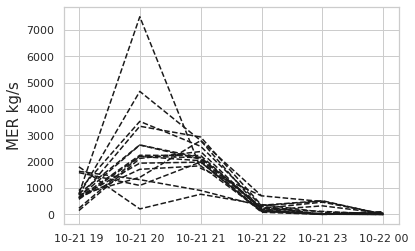

In [494]:
%autoreload
# creates emit-times, CONTROL and SETUP files for HYSPLIT runs.
# Note that warning that meteorological files not found is ok.

%autoreload

tiilist = [[2,3],[2,3,4],[2,3,4,5],[2,3,4,5,6],[2,3,4,5,6,7],[2,3,4,5,6,7,8],[2,3,4,5,6,7,8,9],
           [2,3,4,5,6,7,8,9,10],[2,3,4,5,6,7,8,9,10,11]]  #times to assimilate in inversion algorithm.
remove_cols=True    # removes columns with no model values in them.
remove_rows=False    # removes clear sky observations
remove_sources = False
remove_ncs=5
for tii in tiilist[2:]:
    print('tii', tii)
    makerun(tii,remove_cols,remove_rows,remove_sources,remove_ncs)
    inverse.make_efile(vloc=vloc)
    inverse.run_hysplit()

tiilist = [[2,3],[3,4],[4,5],[5,6],[6,7],[7,8],[8,9],[9,10],[10,11]]
remove_cols=True    # removes columns with no model values in them.
remove_rows=False    # removes clear sky observations
remove_sources = False
remove_ncs=5
for tii in tiilist:
    makerun(tii,remove_cols,remove_rows,remove_sources,remove_ncs)
    inverse.make_efile(vloc=vloc)
    inverse.run_hysplit()

## For comparision with RunC

2020-10-21T21:00:00.000000000
2020-10-21T22:00:00.000000000
(2671, 45)
N_ctrl 44
output file /hysplit-users/alicec/projects/bezy/RunB/RunB_2_3_TFw5/runB4.tcm_bezyB.txt


/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:829: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return t3, lat, lon
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:830: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:844: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating t

bezyB
saving to  /hysplit-users/alicec/projects/bezy/RunB/RunB_2_3_TFw5/RunB_2_3_TFw5.csv
2020-10-21T21:00:00.000000000
2020-10-21T22:00:00.000000000
2020-10-21T23:00:00.000000000
(4904, 56)
N_ctrl 55
output file /hysplit-users/alicec/projects/bezy/RunB/RunB_2_3_4_TFw5/runB4.tcm_bezyB.txt


/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:829: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return t3, lat, lon
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:830: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:844: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating t

bezyB


/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:596: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  def make_tcm_mult(self,tiilist,remove_cols=True,remove_rows=True,
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:829: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return t3, lat, lon
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:830: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or nda

saving to  /hysplit-users/alicec/projects/bezy/RunB/RunB_2_3_4_TFw5/RunB_2_3_4_TFw5.csv
2020-10-21T23:00:00.000000000
2020-10-22T00:00:00.000000000
2020-10-22T01:00:00.000000000
(9043, 67)
N_ctrl 66
output file /hysplit-users/alicec/projects/bezy/RunB/RunB_4_5_6_TFw5/runB4.tcm_bezyB.txt
bezyB


/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:596: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  def make_tcm_mult(self,tiilist,remove_cols=True,remove_rows=True,
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:829: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return t3, lat, lon
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:830: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or nda

saving to  /hysplit-users/alicec/projects/bezy/RunB/RunB_4_5_6_TFw5/RunB_4_5_6_TFw5.csv
2020-10-21T21:00:00.000000000
2020-10-21T22:00:00.000000000
(202, 45)
N_ctrl 44
output file /hysplit-users/alicec/projects/bezy/RunB/RunB_2_3_TT/runB4.tcm_bezyB.txt
bezyB


/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:596: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  def make_tcm_mult(self,tiilist,remove_cols=True,remove_rows=True,
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:829: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return t3, lat, lon
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:830: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or nda

saving to  /hysplit-users/alicec/projects/bezy/RunB/RunB_2_3_TT/RunB_2_3_TT.csv
2020-10-21T21:00:00.000000000
2020-10-21T22:00:00.000000000
2020-10-21T23:00:00.000000000
(421, 56)
N_ctrl 55
output file /hysplit-users/alicec/projects/bezy/RunB/RunB_2_3_4_TT/runB4.tcm_bezyB.txt
bezyB


/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:596: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  def make_tcm_mult(self,tiilist,remove_cols=True,remove_rows=True,
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:829: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return t3, lat, lon
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:830: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or nda

saving to  /hysplit-users/alicec/projects/bezy/RunB/RunB_2_3_4_TT/RunB_2_3_4_TT.csv
2020-10-21T23:00:00.000000000
2020-10-22T00:00:00.000000000
2020-10-22T01:00:00.000000000
(610, 67)
N_ctrl 66
output file /hysplit-users/alicec/projects/bezy/RunB/RunB_4_5_6_TT/runB4.tcm_bezyB.txt
bezyB


/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:596: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  def make_tcm_mult(self,tiilist,remove_cols=True,remove_rows=True,
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:829: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return t3, lat, lon
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:830: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or nda

saving to  /hysplit-users/alicec/projects/bezy/RunB/RunB_4_5_6_TT/RunB_4_5_6_TT.csv
2020-10-21T21:00:00.000000000
2020-10-21T22:00:00.000000000
(2933, 45)
N_ctrl 44
output file /hysplit-users/alicec/projects/bezy/RunB/RunB_2_3_TF/runB4.tcm_bezyB.txt
bezyB


/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:596: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  def make_tcm_mult(self,tiilist,remove_cols=True,remove_rows=True,
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:829: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return t3, lat, lon
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:830: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or nda

saving to  /hysplit-users/alicec/projects/bezy/RunB/RunB_2_3_TF/RunB_2_3_TF.csv
2020-10-21T21:00:00.000000000
2020-10-21T22:00:00.000000000
2020-10-21T23:00:00.000000000
(5381, 56)
N_ctrl 55
output file /hysplit-users/alicec/projects/bezy/RunB/RunB_2_3_4_TF/runB4.tcm_bezyB.txt
bezyB


/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:596: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  def make_tcm_mult(self,tiilist,remove_cols=True,remove_rows=True,
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:829: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return t3, lat, lon
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:830: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or nda

saving to  /hysplit-users/alicec/projects/bezy/RunB/RunB_2_3_4_TF/RunB_2_3_4_TF.csv
2020-10-21T23:00:00.000000000
2020-10-22T00:00:00.000000000
2020-10-22T01:00:00.000000000
(9846, 67)
N_ctrl 66
output file /hysplit-users/alicec/projects/bezy/RunB/RunB_4_5_6_TF/runB4.tcm_bezyB.txt
bezyB


/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:596: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  def make_tcm_mult(self,tiilist,remove_cols=True,remove_rows=True,
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:829: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return t3, lat, lon
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:830: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or nda

saving to  /hysplit-users/alicec/projects/bezy/RunB/RunB_4_5_6_TF/RunB_4_5_6_TF.csv
2020-10-22T02:00:00.000000000
2020-10-22T03:00:00.000000000
(10153, 67)
N_ctrl 66
output file /hysplit-users/alicec/projects/bezy/RunB/RunB_7_8_TFw7/runB4.tcm_bezyB.txt
bezyB


/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:596: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  def make_tcm_mult(self,tiilist,remove_cols=True,remove_rows=True,
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:829: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return t3, lat, lon
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:830: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or nda

saving to  /hysplit-users/alicec/projects/bezy/RunB/RunB_7_8_TFw7/RunB_7_8_TFw7.csv
2020-10-22T04:00:00.000000000
2020-10-22T05:00:00.000000000
2020-10-22T06:00:00.000000000
(22704, 67)
N_ctrl 66
output file /hysplit-users/alicec/projects/bezy/RunB/RunB_9_10_11_TFw7/runB4.tcm_bezyB.txt
bezyB


/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:596: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  def make_tcm_mult(self,tiilist,remove_cols=True,remove_rows=True,
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:829: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return t3, lat, lon
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:830: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or nda

saving to  /hysplit-users/alicec/projects/bezy/RunB/RunB_9_10_11_TFw7/RunB_9_10_11_TFw7.csv
2020-10-21T21:00:00.000000000
2020-10-21T22:00:00.000000000
2020-10-21T23:00:00.000000000
2020-10-22T00:00:00.000000000
2020-10-22T01:00:00.000000000
2020-10-22T02:00:00.000000000
2020-10-22T03:00:00.000000000
2020-10-22T04:00:00.000000000
2020-10-22T05:00:00.000000000
2020-10-22T06:00:00.000000000
(44060, 67)
N_ctrl 66
output file /hysplit-users/alicec/projects/bezy/RunB/RunB_2_3_4_5_6_7_8_9_10_11_TFw7/runB4.tcm_bezyB.txt
bezyB


/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:596: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  def make_tcm_mult(self,tiilist,remove_cols=True,remove_rows=True,
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:829: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return t3, lat, lon
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:830: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or nda

saving to  /hysplit-users/alicec/projects/bezy/RunB/RunB_2_3_4_5_6_7_8_9_10_11_TFw7/RunB_2_3_4_5_6_7_8_9_10_11_TFw7.csv
2020-10-22T02:00:00.000000000
2020-10-22T03:00:00.000000000
(583, 64)
N_ctrl 63
output file /hysplit-users/alicec/projects/bezy/RunB/RunB_7_8_TT/runB4.tcm_bezyB.txt
bezyB


/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:596: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  def make_tcm_mult(self,tiilist,remove_cols=True,remove_rows=True,
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:829: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return t3, lat, lon
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:830: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or nda

saving to  /hysplit-users/alicec/projects/bezy/RunB/RunB_7_8_TT/RunB_7_8_TT.csv
2020-10-22T04:00:00.000000000
2020-10-22T05:00:00.000000000
2020-10-22T06:00:00.000000000
(958, 64)
N_ctrl 63
output file /hysplit-users/alicec/projects/bezy/RunB/RunB_9_10_11_TT/runB4.tcm_bezyB.txt
bezyB


/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:596: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  def make_tcm_mult(self,tiilist,remove_cols=True,remove_rows=True,
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:829: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return t3, lat, lon
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:830: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or nda

saving to  /hysplit-users/alicec/projects/bezy/RunB/RunB_9_10_11_TT/RunB_9_10_11_TT.csv
2020-10-21T21:00:00.000000000
2020-10-21T22:00:00.000000000
2020-10-21T23:00:00.000000000
2020-10-22T00:00:00.000000000
2020-10-22T01:00:00.000000000
2020-10-22T02:00:00.000000000
2020-10-22T03:00:00.000000000
2020-10-22T04:00:00.000000000
2020-10-22T05:00:00.000000000
2020-10-22T06:00:00.000000000
(2353, 67)
N_ctrl 66
output file /hysplit-users/alicec/projects/bezy/RunB/RunB_2_3_4_5_6_7_8_9_10_11_TT/runB4.tcm_bezyB.txt
bezyB


/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:596: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  def make_tcm_mult(self,tiilist,remove_cols=True,remove_rows=True,
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:829: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return t3, lat, lon
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:830: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or nda

saving to  /hysplit-users/alicec/projects/bezy/RunB/RunB_2_3_4_5_6_7_8_9_10_11_TT/RunB_2_3_4_5_6_7_8_9_10_11_TT.csv
2020-10-22T02:00:00.000000000
2020-10-22T03:00:00.000000000
(11308, 67)
N_ctrl 66
output file /hysplit-users/alicec/projects/bezy/RunB/RunB_7_8_TF/runB4.tcm_bezyB.txt
bezyB


/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:596: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  def make_tcm_mult(self,tiilist,remove_cols=True,remove_rows=True,
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:829: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return t3, lat, lon
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:830: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or nda

saving to  /hysplit-users/alicec/projects/bezy/RunB/RunB_7_8_TF/RunB_7_8_TF.csv
2020-10-22T04:00:00.000000000
2020-10-22T05:00:00.000000000
2020-10-22T06:00:00.000000000
(24997, 67)
N_ctrl 66
output file /hysplit-users/alicec/projects/bezy/RunB/RunB_9_10_11_TF/runB4.tcm_bezyB.txt
bezyB


/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:596: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  def make_tcm_mult(self,tiilist,remove_cols=True,remove_rows=True,
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:829: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return t3, lat, lon
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:830: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or nda

saving to  /hysplit-users/alicec/projects/bezy/RunB/RunB_9_10_11_TF/RunB_9_10_11_TF.csv
2020-10-21T21:00:00.000000000
2020-10-21T22:00:00.000000000
2020-10-21T23:00:00.000000000
2020-10-22T00:00:00.000000000
2020-10-22T01:00:00.000000000
2020-10-22T02:00:00.000000000
2020-10-22T03:00:00.000000000
2020-10-22T04:00:00.000000000
2020-10-22T05:00:00.000000000
2020-10-22T06:00:00.000000000
(49084, 67)
N_ctrl 66
output file /hysplit-users/alicec/projects/bezy/RunB/RunB_2_3_4_5_6_7_8_9_10_11_TF/runB4.tcm_bezyB.txt
bezyB
saving to  /hysplit-users/alicec/projects/bezy/RunB/RunB_2_3_4_5_6_7_8_9_10_11_TF/RunB_2_3_4_5_6_7_8_9_10_11_TF.csv


/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:596: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  def make_tcm_mult(self,tiilist,remove_cols=True,remove_rows=True,


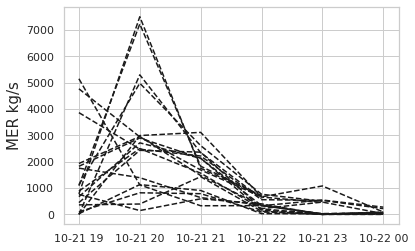

In [483]:
%autoreload
tiilist = [[2,3],[2,3,4],[2,3,4,5],[2,3,4,5,6],[2,3,4,5,6,7],[2,3,4,5,6,7,8],[2,3,4,5,6,7,8,9],
           [2,3,4,5,6,7,8,9,10],[2,3,4,5,6,7,8,9,10,11],
           [4,5,6]]  #times to assimilate in inversion algorithm.
remove_cols=True    # removes columns with no model values in them.
remove_rows=False    # removes clear sky observations
remove_sources = False
remove_ncs=5
for tii in tiilist:
    makerun(tii,remove_cols,remove_rows,remove_sources,remove_ncs)
remove_rows=True
remove_ncs=0
for tii in tiilist:
    makerun(tii,remove_cols,remove_rows,remove_sources,remove_ncs)
remove_rows=False
remove_ncs=0
for tii in tiilist:
    makerun(tii,remove_cols,remove_rows,remove_sources,remove_ncs)
    
    
tiilist = [[7,8],[9,10,11],[2,3,4,5,6,7,8,9,10,11]]  #times to assimilate in inversion algorithm.
remove_cols=True    # removes columns with no model values in them.
remove_rows=False    # removes clear sky observations
remove_sources = False
remove_ncs=7
for tii in tiilist:
    makerun(tii,remove_cols,remove_rows,remove_sources,remove_ncs)
remove_rows=True
remove_ncs=0
for tii in tiilist:
    makerun(tii,remove_cols,remove_rows,remove_sources,remove_ncs)
remove_rows=False
remove_ncs=0
for tii in tiilist:
    makerun(tii,remove_cols,remove_rows,remove_sources,remove_ncs)  
    

# Looking at inidividual inversions

In [515]:
%autoreload
tii = [2,3]  #times to assimilate in inversion algorithm.
remove_cols=True    # removes columns with no model values in them.
remove_rows=False    # removes clear sky observations
remove_sources = False
remove_ncs=5
#remove_sources = ['12880']  # this would remove top vertical level from consideration.
#inverse.make_tcm_mult([1,2,3,4],remove_cols=True,remove_rows=False,remove_sources=['12880'])
inverse.make_tcm_mult(tii,remove_cols=remove_cols, remove_rows=remove_rows, remove_sources=remove_sources,remove_ncs=remove_ncs)
runtag = ai.create_runtag(tag,tii,remove_cols, remove_rows, remove_sources,remove_ncs=remove_ncs)

# set the subdirectory for this TCM run.
#subdir = inverse.set_sub_directory(runtag)
#print('setting subdirectory {}'.format(subdir))

2020-10-21T21:00:00.000000000
2020-10-21T22:00:00.000000000


/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:829: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.latlist = np.array(latlist)
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:830: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.lonlist = np.array(lonlist)
/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:844: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, yo

In [ ]:
print(runtag)

In [ ]:
numpar = 20000  # number of particles released per hour.
delt = 5 # time step
tave = 1 # 1 h time average
hres = 0.1 # 0.1 degree horizontal resolution.
rate = 1 # 1 unit mass per hour
particle_mass = rate / numpar  #how much unit mass each particle has
area = (hres * 111e3)**2  # area in meters squared for mass loading grid.
mass_one = particle_mass / area  # unit mass / m2 for one particle in grid box.
mass_one_one = mass_one / (tave*60 / delt)  # smallest mass loading possible with one particle for one time step
print(mass_one_one)  # one particle for one time step
print(mass_one)      # one particle in area.

/hysplit-users/alicec/utilhysplit/utilvolc/ash_inverse.py:967: RuntimeWarning: divide by zero encountered in log10
  cb = plt.pcolormesh(np.log10(self.tcm),cmap='tab20')


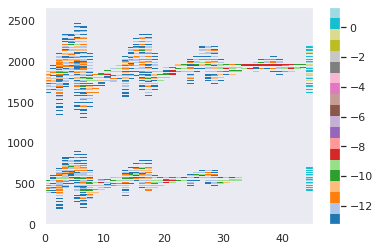

(2671, 45)

In [421]:
%autoreload
inverse.plot_tcm()
inverse.invlist[0].tcm.shape


In [422]:
#hysplitdir = '/hysplit-users/alicec/FBamcArea/exec/'
#inverse.set_directory(wdir,execdir,hysplitdir)
inverse.set_subdirectory(runtag)

'/hysplit-users/alicec/projects/bezy/RunB/RunB_2_3_TFw5'

In [423]:
%autoreload
tcmstr = inverse.write_tcm(os.path.join(inverse.subdir, tcm_name_base.replace('zzz','4')))
#print(tcmstr)

(2671, 45)
N_ctrl 44
output file /hysplit-users/alicec/projects/bezy/RunB/RunB_2_3_TFw5/runB4.tcm_bezyB.txt


In [424]:
%autoreload
#hysplitdir = '/hysplit-users/alicec/FBamcArea/exec/'
#inverse.set_directory(wdir,execdir,hysplitdir)
inverse.run_tcm()

bezyB


In [425]:
# Now run the inverse model.

# open the Parameters_in.dat file and set N_ctrl, Nx_ctrl and lbfgs_nbd to
# the number shown for N_ctrl above.

# copy the tcm file to TCM_sum.csv

# run new_lbfgsb.x

In [426]:
10**0.0007

1.001613109228309

bezyB


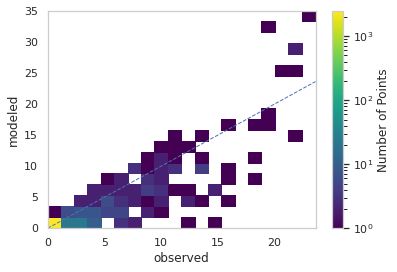

In [427]:
%autoreload
inverse.plot_outdat(eii=None)

In [428]:
print(inverse.make_tcm_names())
print(inverse.subdir)

(['bezyB_out.dat'], ['bezyB_out2.dat'])
/hysplit-users/alicec/projects/bezy/RunB/RunB_2_3_TFw5


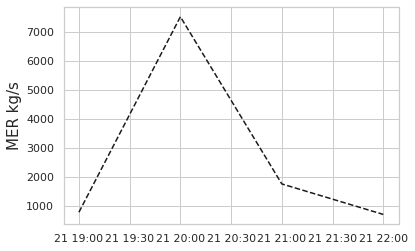

total 0.03868999104893059 Tg


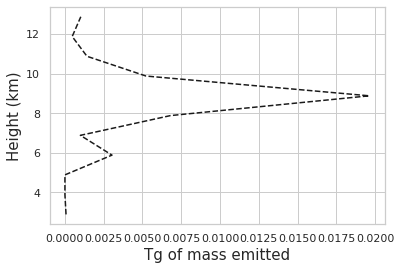

In [430]:
%autoreload

eii=None
unit='g/h'
unit='kg/s'
inverse.plot_outdat_ts(eii,unit=unit)
plt.show()
inverse.plot_outdat_ts(eii,profile=True)
inverse.save_emis(runtag+'.csv')
#ax = plt.gca()
#ax.set_ylim(0,10000)

In [431]:
#%autoreload
#inverse.sourcehash = ai.get_sourcehash(configdir,configfile)

bezyB


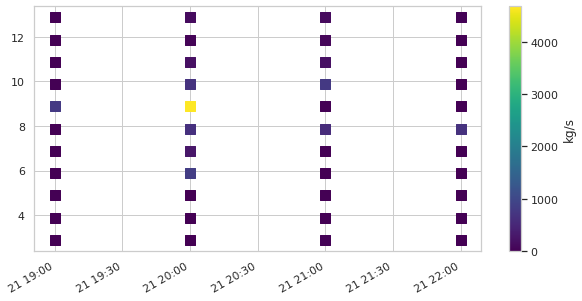

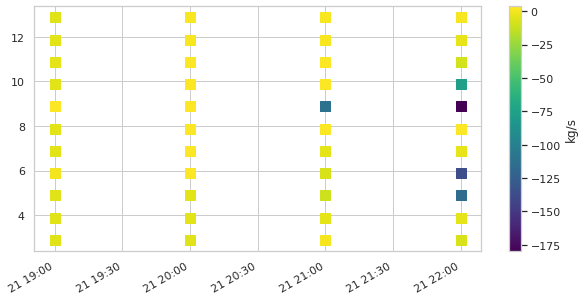

In [432]:
%autoreload
unit='kg/s'
#unit='g/h'
iii=0
print(inverse.taglist[iii])
ilist =  inverse.read_outdat()
df = ilist[iii].get_emis()
vals = inverse.invlist[iii].make_outdat(df)
inverse.invlist[iii].plot_outdat(vals,log=False,cmap='viridis',unit=unit)
#plt.savefig('{}.emissions_log.png'.format(figbase))
plt.show()
inverse.invlist[0].plot_outdat(vals,log=True,cmap='viridis',unit=unit)
#plt.savefig('{}.emissions.png'.format(figbase))


In [433]:
inverse.invlist[0].inp

{'HYSPLIT_DIR': '../',
 'MAP_DIR': '/hysplit-users/alicec/hysplit.v5.0.0/graphics/',
 'WORK_DIR': '/hysplit-users/alicec/tmp/',
 'CONVERT_EXE': 'convert',
 'PYTHON_EXE': '/hysplit-users/alicec/anaconda3/envs/hysplit/bin/python',
 'forecastDirectory': '/pub/forecast',
 'archivesDirectory': '/pub/archives',
 'GHOSTSCRIPT_EXE': 'gs',
 'DATA_DIR': '/hysplit-users/alicec/utilhysplit/utilvolc/ashapp/',
 'owner': 'A. Person',
 'VolcanoName': 'Bezymianny',
 'area': 785000.0,
 'top': 12880.0,
 'bottom': 2880.0,
 'start_date': datetime.datetime(2020, 10, 21, 19, 0),
 'durationOfSimulation': 12.0,
 'testminutes': 0.0,
 'emissionHours': 6.0,
 'meteorologicalData': 'gfs0p25',
 'EruptionSize': 0.0,
 'latitude': 55.978,
 'longitude': 160.587,
 'samplingIntervalHours': 1.0,
 'eflag': 0.0,
 'source_type': 'uniform',
 'jobname': 'ashtest',
 'runflag': 'inverse',
 'timeres': 1,
 'rate': 1,
 'inv_vertical_resolution': 1000,
 'gisOption': 3,
 'zoomFactor': 50,
 'generatingPostscript': True,
 'generatingPDF

In [434]:
%autoreload
inverse.print_directories()

Working directory, wdir :/hysplit-users/alicec/projects/bezy/RunB
execdir :/hysplit-users/alicec/projects/bezy/Inverse_240
hysplitdir :/hysplit-users/alicec/projects/bezy/hysplit
subdir :/hysplit-users/alicec/projects/bezy/RunB/RunB_2_3_TFw5
vdir :/hysplit-users/alicec/projects/bezy/data/volcat
datadir :/hysplit-users/alicec/projects/bezy/data


In [435]:
%autoreload
# creates emit-times, CONTROL and SETUP files for HYSPLIT runs.
# Note that warning that meteorological files not found is ok.
inverse.make_efile(vloc=vloc)

No meteorological files found /hysplit-users/alicec/projects/bezy/data/%Y%m%d/hysplit.t%Hz.gfs0p25f


writing efile {} /hysplit-users/alicec/projects/bezy/RunB/RunB_2_3_TFw5/bezyB_emit.txt
gfs0p25
fcst str /pub/forecast/%Y%m%d/
making control file  gfs0p25
/hysplit-users/alicec/projects/bezy/data/
fcst str /hysplit-users/alicec/projects/bezy/data/%Y%m%d/
WARNING /hysplit-users/alicec/projects/bezy/data/20201021/hysplit.t18z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t00z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t06z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t12z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201022/hysplit.t18z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/20201023/hysplit.t00z.gfs0p25f meteorological file does not exist
WARNING /hysplit-users/alicec/projects/bezy/data/202010

In [436]:
%autoreload
inverse.run_hysplit()

running  /hysplit-users/alicec/projects/bezy/hysplit/exec/hycs_std bezyB
in loop 0s procs 1
in loop 30s procs 1
in loop 60s procs 1
in loop 90s procs 1
in loop 120s procs 1
in loop 150s procs 1
in loop 180s procs 1
in loop 210s procs 1
in loop 240s procs 1
in loop 270s procs 1
in loop 300s procs 1
in loop 330s procs 1
in loop 360s procs 1
in loop 390s procs 1
in loop 420s procs 1
in loop 450s procs 0


# Creating netcdf files from cdump

In [113]:
runtag = 'RunB_5_TT'
runtag = 'RunB_2_3_4_TF'
runtag = 'RunB_2_3_4_TT'
runtag = 'RunB_7_TT'
inverse.set_subdirectory(runtag)

'/hysplit-users/alicec/projects/bezy/RunB/RunB_7_TT'

In [114]:
%autoreload
# converts cdump to netcdf file.
#dset = inverse.create_emit_output(inverse.subdir + '/Run{}.nc'.format(tag))

In [115]:
#for attr in dset.attrs: print(type(dset.attrs[attr]), attr)

In [194]:
blist = []
for iii, subdir in enumerate(runtag):
    #print(subdir)
    inverse.set_subdirectory(subdir)
    #print(inverse.subdir)
    if os.path.isfile(os.path.join(inverse.subdir,'cdump.bezyB')):
       blist.append([os.path.join(inverse.subdir,'cdump.bezyB'),'gfs0p25',subdir])


#cdir = '/hysplit-users/alicec/projects/bezy/RunB/'
#tags = ['RunC_2_3_4_TFw5', 'RunC_4_5_6_TFw5', 'RunC_7_8_TFw7','RunC_9_10_11_TFw7']
#name = 'cdump.bezyC'
#for tag in tags:
#    blist.append((os.path.join(cdir,tag,name),'gfs0p25',tag))
    
cdir = '/hysplit-users/alicec/projects/bezy/RunC/'
tags = ['RunC_2_3_4_TFw5', 'RunC_4_5_6_TFw5', 'RunC_7_8_TFw7','RunC_9_10_11_TFw7']
name = 'cdump.bezyC'
for tag in tags:
    blist.append((os.path.join(cdir,tag,name),'gfs0p25',tag))



cdir = '/hysplit-users/alicec/projects/bezy/RunD/'
tags = ['RunD_2_3_4_TFw5', 'RunD_4_5_6_TFw5', 'RunD_7_8_TFw7','RunD_9_10_11_TFw7']
tags.append('RunD_2_3_4_5_6_7_8_9_10_11_TFw7')
tags.append('RunD_2_3_4_5_6_7_8_9_10_11_TT')
name = 'cdump.ezyD1'
for tag in tags:
    blist.append((os.path.join(cdir,tag,name),'gfs0p25',tag))

for bl in blist: 
    print(bl)
    print(os.path.isfile(bl[0]))
#dset = hysplit.combine_dataset(blist)

['/hysplit-users/alicec/projects/bezy/RunB/RunB_2_3_4_TF/cdump.bezyB', 'gfs0p25', 'RunB_2_3_4_TF']
True
['/hysplit-users/alicec/projects/bezy/RunB/RunB_2_3_4_TFw5/cdump.bezyB', 'gfs0p25', 'RunB_2_3_4_TFw5']
True
['/hysplit-users/alicec/projects/bezy/RunB/RunB_4_5_6_TFw5/cdump.bezyB', 'gfs0p25', 'RunB_4_5_6_TFw5']
True
['/hysplit-users/alicec/projects/bezy/RunB/RunB_7_8_TFw7/cdump.bezyB', 'gfs0p25', 'RunB_7_8_TFw7']
True
['/hysplit-users/alicec/projects/bezy/RunB/RunB_2_3_4_TT/cdump.bezyB', 'gfs0p25', 'RunB_2_3_4_TT']
True
['/hysplit-users/alicec/projects/bezy/RunB/RunB_2_3_4_5_6_7_8_9_10_11_TTw7/cdump.bezyB', 'gfs0p25', 'RunB_2_3_4_5_6_7_8_9_10_11_TTw7']
True
['/hysplit-users/alicec/projects/bezy/RunB/RunB_2_3_4_5_6_7_8_9_10_11_TF/cdump.bezyB', 'gfs0p25', 'RunB_2_3_4_5_6_7_8_9_10_11_TF']
True
('/hysplit-users/alicec/projects/bezy/RunC/RunC_2_3_4_TFw5/cdump.bezyC', 'gfs0p25', 'RunC_2_3_4_TFw5')
True
('/hysplit-users/alicec/projects/bezy/RunC/RunC_4_5_6_TFw5/cdump.bezyC', 'gfs0p25', 'Run

In [ ]:
dset.ens.values
dset.to_netcdf(os.path.join(inverse.wdir,'RunGFS2.nc'))

bezyB


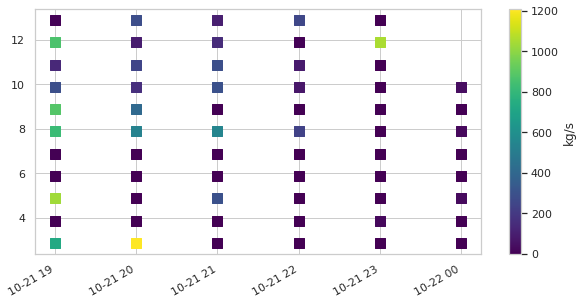

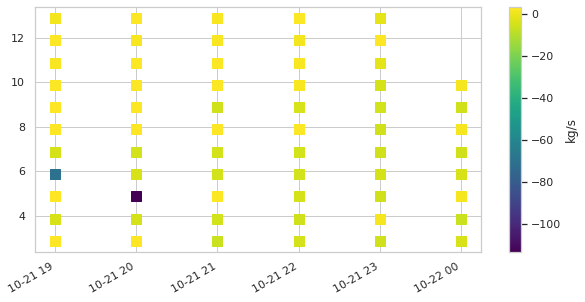

In [74]:
%autoreload
unit='kg/s'
#unit='g/h'
iii=0
print(inverse.taglist[iii])
ilist =  inverse.read_outdat()
df = ilist[iii].get_emis()
vals = inverse.invlist[iii].make_outdat(df)
inverse.invlist[iii].plot_outdat(vals,log=False,cmap='viridis',unit=unit)
#plt.savefig('{}.emissions_log.png'.format(figbase))
plt.show()
inverse.invlist[0].plot_outdat(vals,log=True,cmap='viridis',unit=unit)
#plt.savefig('{}.emissions.png'.format(figbase))

In [46]:
v8, c8 = inverse.invlist[0].get_pair(4)

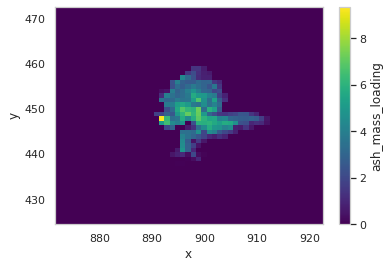

In [47]:
v8.plot.pcolormesh()

In [49]:
test1 = xr.where(test>0,True,False)
test2 = xr.where(v8>0,True,False)

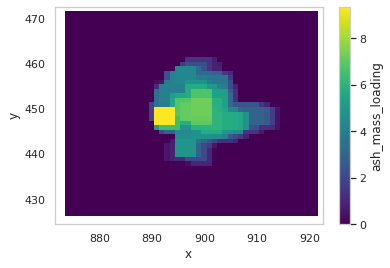

In [48]:
spread=4
test = v8.rolling(x=spread,center=True).max()
test = test.rolling(y=spread,center=True).max()
test.plot.pcolormesh()

In [50]:
test1

<xarray.DataArray 'ash_mass_loading' (y: 48, x: 51)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * y          (y) int64 425 426 427 428 429 430 431 ... 467 468 469 470 471 472
  * x          (x) int64 872 873 874 875 876 877 878 ... 917 918 919 920 921 922
    latitude   (y, x) float64 53.38 53.38 53.38 53.38 ... 58.08 58.08 58.08
    longitude  (y, x) float64 157.7 157.8 157.9 158.0 ... 162.5 162.6 162.7

In [51]:
np.all([test1,test2],axis=0).shape

(48, 51)

In [52]:
test3 = xr.where(np.any([test1,test2],axis=0), v8, -1)

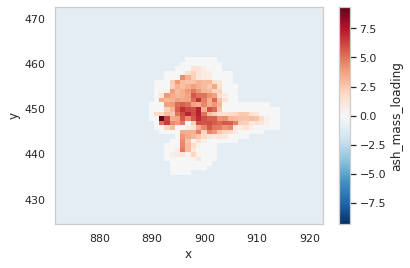

In [53]:
test3.plot.pcolormesh()

In [54]:
1.5e4*1e3*3600 / 1e12

0.054

In [495]:
datetime.timedelta(hours=1)

datetime.timedelta(seconds=3600)